# Use Fischer's Exact test to identify assays first


The first cell commented out as raw is the called to group the best model for each unique casn.  This is the same code that was used to create the 'best_models' collection on LiverToxCast.  

In [1]:
import pandas as pd, numpy as np
import pymongo, toxcast

client = pymongo.MongoClient()


hit_calls = pd.DataFrame(list(client.LiverToxCast.hit_calls.aggregate([{'$project': {'aeid':'$_id.aeid', 'casn': '$_id.casn', 'hitc':'$hitc'}}])))

In [2]:
hit_calls

,_id,aeid,casn,hitc
0,"{'aeid': 2, 'casn': '100-00-5'}",2,100-00-5,0
1,"{'aeid': 2, 'casn': '100-01-6'}",2,100-01-6,0
2,"{'aeid': 2, 'casn': '100-02-7'}",2,100-02-7,0
3,"{'aeid': 2, 'casn': '100-06-1'}",2,100-06-1,1
4,"{'aeid': 2, 'casn': '100-10-7'}",2,100-10-7,0
...,...,...,...,...
3173378,"{'aeid': 2533, 'casn': 'NOCAS_47342'}",2533,NOCAS_47342,1
3173379,"{'aeid': 2533, 'casn': 'NOCAS_47353'}",2533,NOCAS_47353,1
3173380,"{'aeid': 2533, 'casn': 'NOCAS_47377'}",2533,NOCAS_47377,1
3173381,"{'aeid': 2533, 'casn': 'NOCAS_47387'}",2533,NOCAS_47387,0


Just get the compounds that have data for the target endpoints of interest, i.e., the human hc, animal hc, etc.  Merge this with their hit calls from the Tox21/ToxCast data.

In [5]:
target_endpoints = ['human_hb', 'human_hc']

In [6]:
liver_data_df = pd.DataFrame(client.LiverToxCast.modeling_set.find({}, {"_id":0, "CASRN": 0}))
modeling_set.head()

,rdkitInChIClean,casn,DILIRank_call,linlin_call,H_HT_class,PC_CCHC_class,PC_CC_class,PC_HT_class,PC_MFHC_class,PC_MF_class,...,PC_HTdl500_class,PC_MFHB_class,PC_MFHBdl500_class,PC_MFHCdl500_class,PC_MFdl500_class,human_hb,animal_hb,animal_dl500_hb,human_hc,animal_dl500_hc
0,InChI=1S/2Bi.3O,1304-76-3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,InChI=1S/2BrH.Ca/h2*1H;/q;;+2/p-2,7789-41-5,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,"InChI=1S/2C10H19NO5/c2*1-10(2,6-12)8(15)9(16)1...",17097-76-6,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,InChI=1S/2C12H24O2.2C4H9.Sn/c2*1-2-3-4-5-6-7-8...,77-58-7,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,"InChI=1S/2C2H4O2.Al.H2O/c2*1-2(3)4;;/h2*1H3,(H...",142-03-0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [7]:
mulliner_cmps = liver_data_df[['casn'] + target_endpoints]
mulliner_cmps = mulliner_cmps[mulliner_cmps[target_endpoints].notnull().any(1)]

In [8]:
fisher_test_frame = hit_calls[['aeid', 'casn', 'hitc']].merge(mulliner_cmps)
fisher_test_frame

,aeid,casn,hitc,human_hb,human_hc
0,2,100-51-6,0,0.0,0.0
1,23,100-51-6,0,0.0,0.0
2,24,100-51-6,0,0.0,0.0
3,25,100-51-6,0,0.0,0.0
4,26,100-51-6,0,0.0,0.0
...,...,...,...,...,...
457699,2452,59-43-8,0,0.0,0.0
457700,2453,59-43-8,0,0.0,0.0
457701,2451,91714-94-2,0,1.0,1.0
457702,2452,91714-94-2,0,1.0,1.0


Create a dataframe of contigency tables, delineating the number of active/tox, active/non-tox etc. for each endpoint and for each ToxCast aeid. 

In [9]:
contingency_tables = []
for endpoint in target_endpoints:
    for aeid, aeid_data in fisher_test_frame.groupby('aeid'):
        active_with_endpoint = ((aeid_data.hitc == 1) & (aeid_data[endpoint] == 1)).sum()
        active_without_endpoint = ((aeid_data.hitc == 1) & (aeid_data[endpoint] == 0)).sum()

        inactive_with_endpoint = ((aeid_data.hitc == 0) & (aeid_data[endpoint] == 1)).sum()
        inactive_without_endpoint = ((aeid_data.hitc == 0) & (aeid_data[endpoint] == 0)).sum()
        contingency_tables.append([endpoint, aeid, active_with_endpoint, active_without_endpoint, inactive_with_endpoint, inactive_without_endpoint])
contingency_tables = pd.DataFrame(contingency_tables) 
contingency_tables.columns = ['endpoint', 'aeid', 'active_tox', 'active_nontox', 'inactive_tox', 'inactive_nontox']

### fisher's exact test

Contingency looks like this 

 
 $$\begin{pmatrix}active tox & inactive tox\\\ active non tox & inactive nontox\end{pmatrix}$$

I am only looking for those with a greater response.  Reference for the test: https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.fisher_exact.html


In [10]:
from scipy.stats import fisher_exact

In [11]:
fisher_results = []
for (ep, aeid), data in contingency_tables.groupby(['endpoint', 'aeid']):
    'active_tox', 'active_nontox', 'inactive_tox', 'inactive_nontox'
    ct = [
        [data.active_tox.iloc[0], data.active_nontox.iloc[0]],
        [data.inactive_tox.iloc[0], data.inactive_nontox.iloc[0]]
    ]
    
    odds, pvalue = fisher_exact(ct, alternative='greater')
    fisher_results.append([ep, aeid, pvalue, odds])
fisher_results = pd.DataFrame(fisher_results)
fisher_results.columns = ['endpoint', 'aeid', 'pvalue', 'odds']

### P-value Distribution

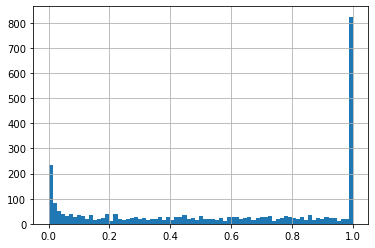

In [12]:
import numpy as np

fisher_results.pvalue.hist(bins=75)

## Correct for multiple hypotheses

Correct using the benjamini-hockenburg procedure as described in Section 13 in Introduction to Statistical Learning.

Sort all pvalues and assign a rank -> j.  Calculate the critical threshold as $qj/m$, where $q$ is the desired false discovery rate and $m$ is the number of pvalues.  Find L, which is the max rank the meets the criteria that the pvalue at that rank is less than the critical threshold. Note: there could be pvalues greater than the critical threshold less than the rank.  Accept all pvalues with a rank less than $L$.

$L = max(\{p(j) < qj/m\})$

In [13]:
pd.options.mode.chained_assignment = None  # default='warn'

In [14]:
results = fisher_results.merge(contingency_tables).sort_values('pvalue')

corrected_results = []

alpha = 0.15

for endpoint, result in results.groupby('endpoint'):

    result.sort_values('pvalue', inplace=True)
    result['Rank'] = list(range(1, result.shape[0]+1))
    

    result['b-h_threshold'.format(alpha)] = alpha*result.Rank/result.shape[0]
    L = result[result['b-h_threshold'] > result.pvalue].Rank.max()
    corrected_results.append(result[result.Rank <= L])
        
corrected_results = pd.concat(corrected_results)

## Merge with gene_target_info

In [15]:
aeid_info = pd.DataFrame(client.LiverToxCast.aeid_info.find({},
                                                            {'_id': 0, 'aeid':1, 'assay_component_endpoint_name':1,
                                                             'assay_function_type': 1, 'intended_target_family_sub': 1}))
gene_target_info = pd.DataFrame(client.LiverToxCast.gene_target.find({},
                                                            {'_id': 0, 'aeid':1, 'official_symbol':1,
                                                             'organism_id': 1, 'source': 1}))

In [16]:
all_data = corrected_results.merge(aeid_info, how='left', on='aeid').merge(gene_target_info, how='left', on='aeid')

In [17]:
grped = all_data.groupby('endpoint')

for ep, data in grped:
    print(ep, data.shape, data.aeid.nunique())

human_hb (153, 16) 148
human_hc (36, 16) 36


In [18]:
pvalue_con = client.LiverToxCast.endpoint_aeid_pvalues2


records = [v.dropna().to_dict() for k,v in all_data.iterrows()]
    
pvalue_con.insert_many(records)

In [19]:
len(records)

189

correcetd plot